In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, vgg16, inception_v3, densenet161
import time

100.0%


Количество классов: 47
Размер тренировочного набора: 112800
Размер тестового набора: 18800
Классы: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

Распределение классов в тренировочном наборе:
Класс 0 (0): 2400 примеров
Класс 1 (1): 2400 примеров
Класс 2 (2): 2400 примеров
Класс 3 (3): 2400 примеров
Класс 4 (4): 2400 примеров
Класс 5 (5): 2400 примеров
Класс 6 (6): 2400 примеров
Класс 7 (7): 2400 примеров
Класс 8 (8): 2400 примеров
Класс 9 (9): 2400 примеров
Класс 10 (A): 2400 примеров
Класс 11 (B): 2400 примеров
Класс 12 (C): 2400 примеров
Класс 13 (D): 2400 примеров
Класс 14 (E): 2400 примеров
Класс 15 (F): 2400 примеров
Класс 16 (G): 2400 примеров
Класс 17 (H): 2400 примеров
Класс 18 (I): 2400 примеров
Класс 19 (J): 2400 примеров
Класс 20 (K): 2400 примеров
Класс 21 (L): 2400 примеров
Класс 22 (M)

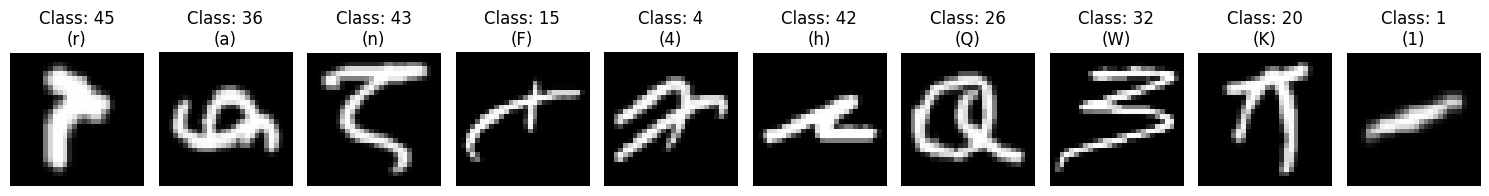

In [2]:
# 1. Загрузка и анализ датасета EMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка EMNIST (используем split 'balanced' для сбалансированных классов)
train_dataset = torchvision.datasets.EMNIST(
    root='./data', 
    split='balanced',
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data', 
    split='balanced',
    train=False, 
    download=True, 
    transform=transform
)

# Посмотрим на информацию о датасете
print(f"Количество классов: {len(train_dataset.classes)}")
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")
print(f"Классы: {train_dataset.classes}")

# Проверим дисбаланс классов
class_counts = {}
for _, label in train_dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

print("\nРаспределение классов в тренировочном наборе:")
for i, count in enumerate(class_counts.values()):
    print(f"Класс {i} ({train_dataset.classes[i]}): {count} примеров")

# Визуализация примеров изображений
def show_examples(dataset, num_examples=10):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Class: {label}\n({train_dataset.classes[label]})')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_examples(train_dataset)

In [3]:
# 2. Создаем DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# 3. Функции для обучения и оценки
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Для Inception v3 - изменяем размер
        if isinstance(model, torchvision.models.Inception3):
            images = torch.nn.functional.interpolate(images, size=(299, 299))
            
            optimizer.zero_grad()
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            if isinstance(model, torchvision.models.Inception3):
                images = torch.nn.functional.interpolate(images, size=(299, 299))
                outputs, _ = model(images)  # Игнорируем aux outputs при тесте
            else:
                outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [35]:
# 4. Функция для создания и модификации моделей
def create_model(model_name, num_classes):
    if model_name == 'resnet18':
        model = resnet18(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    elif model_name == 'vgg16':
        # Упрощенная версия VGG16 для маленьких изображений
        class SimpleVGG(nn.Module):
            def __init__(self, num_classes):
                super(SimpleVGG, self).__init__()
                self.features = nn.Sequential(
                    # Block 1
                    nn.Conv2d(1, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    # Block 2
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    # Block 3
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                )
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 3 * 3, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(512, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(256, num_classes),
                )
            
            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x
        
        model = SimpleVGG(num_classes)
    
    elif model_name == 'inception_v3':
        # Правильная упрощенная версия Inception для EMNIST
        class SimpleInception(nn.Module):
            def __init__(self, num_classes):
                super(SimpleInception, self).__init__()
                
                # Stem layers - уменьшенная версия
                self.stem = nn.Sequential(
                    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                )
                
                # Inception module 1
                self.inception1 = self._make_inception_module(64, 
                                                             conv1x1=32,
                                                             conv3x3_reduce=48, conv3x3=64,
                                                             conv5x5_reduce=8, conv5x5=16,
                                                             pool_proj=16)
                
                # Inception module 2
                self.inception2 = self._make_inception_module(32+64+16+16, 
                                                             conv1x1=64,
                                                             conv3x3_reduce=64, conv3x3=96,
                                                             conv5x5_reduce=16, conv5x5=32,
                                                             pool_proj=32)
                
                # Global pooling и классификатор
                self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
                self.dropout = nn.Dropout(0.4)
                self.fc = nn.Linear(64+96+32+32, num_classes)
            
            def _make_inception_module(self, in_channels, conv1x1, conv3x3_reduce, conv3x3, 
                                      conv5x5_reduce, conv5x5, pool_proj):
                branches = nn.ModuleList()
                
                # 1x1 branch
                branches.append(nn.Sequential(
                    nn.Conv2d(in_channels, conv1x1, kernel_size=1, bias=False),
                    nn.BatchNorm2d(conv1x1),
                    nn.ReLU(inplace=True)
                ))
                
                # 3x3 branch
                branches.append(nn.Sequential(
                    nn.Conv2d(in_channels, conv3x3_reduce, kernel_size=1, bias=False),
                    nn.BatchNorm2d(conv3x3_reduce),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(conv3x3_reduce, conv3x3, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(conv3x3),
                    nn.ReLU(inplace=True)
                ))
                
                # 5x5 branch (упрощенная)
                branches.append(nn.Sequential(
                    nn.Conv2d(in_channels, conv5x5_reduce, kernel_size=1, bias=False),
                    nn.BatchNorm2d(conv5x5_reduce),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(conv5x5_reduce, conv5x5, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(conv5x5),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(conv5x5, conv5x5, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(conv5x5),
                    nn.ReLU(inplace=True)
                ))
                
                # Pool branch
                branches.append(nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, pool_proj, kernel_size=1, bias=False),
                    nn.BatchNorm2d(pool_proj),
                    nn.ReLU(inplace=True)
                ))
                
                return branches
            
            def forward(self, x):
                # Убираем интерполяцию - работаем с оригинальным размером
                x = self.stem(x)
                
                # Inception module 1
                branch_outputs = []
                for branch in self.inception1:
                    branch_outputs.append(branch(x))
                x = torch.cat(branch_outputs, 1)
                
                # Inception module 2
                branch_outputs = []
                for branch in self.inception2:
                    branch_outputs.append(branch(x))
                x = torch.cat(branch_outputs, 1)
                
                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                x = self.dropout(x)
                x = self.fc(x)
                return x
        
        model = SimpleInception(num_classes)
    
    elif model_name == 'densenet161':
            # Упрощенная версия DenseNet для EMNIST
            class SimpleDenseNet(nn.Module):
                def __init__(self, num_classes, growth_rate=32, block_config=(6, 12, 24, 16)):
                    super(SimpleDenseNet, self).__init__()
                    
                    # First convolution
                    self.features = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                    )
                    
                    # Dense blocks (упрощенные)
                    num_features = 64
                    self.dense_blocks = nn.ModuleList()
                    self.transitions = nn.ModuleList()
                    
                    for i, num_layers in enumerate(block_config):
                        # Dense block
                        block = nn.Sequential()
                        for j in range(num_layers):
                            layer = nn.Sequential(
                                nn.BatchNorm2d(num_features + j * growth_rate),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(num_features + j * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False),
                            )
                            block.add_module(f'dense_layer_{j}', layer)
                        
                        self.dense_blocks.append(block)
                        num_features += num_layers * growth_rate
                        
                        # Transition layer (кроме последнего блока)
                        if i != len(block_config) - 1:
                            trans = nn.Sequential(
                                nn.BatchNorm2d(num_features),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(num_features, num_features // 2, kernel_size=1, bias=False),
                                nn.AvgPool2d(kernel_size=2, stride=2),
                            )
                            self.transitions.append(trans)
                            num_features = num_features // 2
                    
                    # Final batch norm
                    self.final_norm = nn.BatchNorm2d(num_features)
                    self.final_relu = nn.ReLU(inplace=True)
                    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
                    
                    # Classifier
                    self.classifier = nn.Linear(num_features, num_classes)
                
                def forward(self, x):
                    x = self.features(x)
                    
                    for i, (block, transition) in enumerate(zip(self.dense_blocks, self.transitions)):
                        # Dense block
                        for layer in block:
                            new_features = layer(x)
                            x = torch.cat([x, new_features], 1)
                        
                        # Transition
                        x = transition(x)
                    
                    # Final block
                    for layer in self.dense_blocks[-1]:
                        new_features = layer(x)
                        x = torch.cat([x, new_features], 1)
                    
                    x = self.final_norm(x)
                    x = self.final_relu(x)
                    x = self.avgpool(x)
                    x = torch.flatten(x, 1)
                    x = self.classifier(x)
                    return x
            
            # Упрощенная конфигурация для маленьких изображений
            model = SimpleDenseNet(num_classes, growth_rate=16, block_config=(3, 6, 12, 8))
    
    return model

In [36]:
# 5. Эксперименты с разными архитектурами
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

num_classes = len(train_dataset.classes)
num_epochs = 1

models_to_train = ['inception_v3', 'densenet161', 'resnet18', 'vgg16']
results = {}

for model_name in models_to_train:
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    # Создаем модель
    model = create_model(model_name, num_classes)
    model = model.to(device)
    
    # Проверяем количество параметров
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Количество параметров: {total_params:,}")
    
    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Списки для сохранения результатов
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    training_times = []
    
    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_model(model, test_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        training_times.append(epoch_time)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print('-' * 40)
    
    # Сохраняем результаты
    results[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'training_times': training_times,
        'final_test_acc': test_accs[-1]
    }
    
    print(f"\nFinal Test Accuracy for {model_name}: {test_accs[-1]:.2f}%")


Using device: cpu

Training inception_v3
Количество параметров: 159,967
Epoch [1/1] - Time: 439.41s
Train Loss: 1.0111, Train Acc: 72.26%
Test Loss: 0.4700, Test Acc: 84.52%
----------------------------------------

Final Test Accuracy for inception_v3: 84.52%

Training densenet161
Количество параметров: 696,773
Epoch [1/1] - Time: 346.95s
Train Loss: 0.5245, Train Acc: 82.83%
Test Loss: 0.3649, Test Acc: 87.21%
----------------------------------------

Final Test Accuracy for densenet161: 87.21%

Training resnet18
Количество параметров: 11,194,351
Epoch [1/1] - Time: 743.73s
Train Loss: 0.5774, Train Acc: 80.63%
Test Loss: 0.4306, Test Acc: 84.70%
----------------------------------------

Final Test Accuracy for resnet18: 84.70%

Training vgg16
Количество параметров: 2,284,719
Epoch [1/1] - Time: 334.17s
Train Loss: 0.8721, Train Acc: 72.40%
Test Loss: 0.3954, Test Acc: 85.75%
----------------------------------------

Final Test Accuracy for vgg16: 85.75%


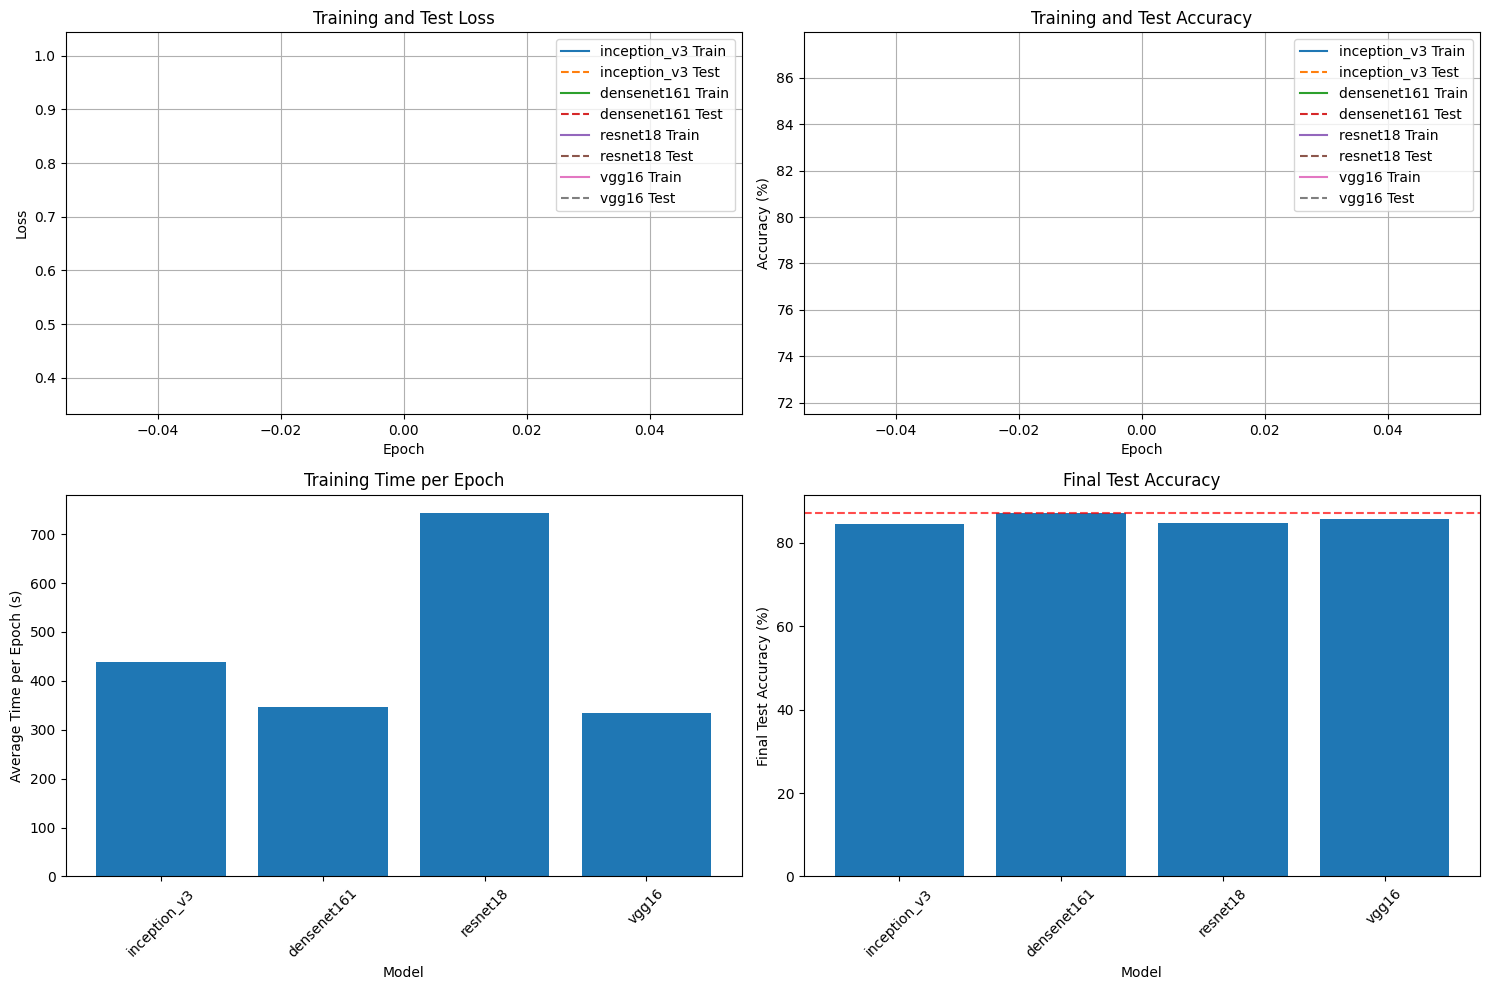

In [ ]:
# 6. Визуализация результатов
plt.figure(figsize=(15, 10))

# Время обучения
plt.subplot(2, 2, 3)
avg_times = [np.mean(result['training_times']) for result in results.values()]
plt.bar(results.keys(), avg_times)
plt.xlabel('Model')
plt.ylabel('Average Time per Epoch (s)')
plt.title('Training Time per Epoch')
plt.xticks(rotation=45)

# Финальная точность
plt.subplot(2, 2, 4)
final_accs = [result['final_test_acc'] for result in results.values()]
plt.bar(results.keys(), final_accs)
plt.xlabel('Model')
plt.ylabel('Final Test Accuracy (%)')
plt.title('Final Test Accuracy')
plt.xticks(rotation=45)
plt.axhline(y=max(final_accs), color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('emnist_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# 7. Сводная таблица результатов
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)

print(f"{'Model':<15} {'Final Train Acc':<15} {'Final Test Acc':<15} {'Avg Time/Epoch':<15}")
print("-" * 60)

for model_name, result in results.items():
    print(f"{model_name:<15} {result['train_accs'][-1]:<15.2f} {result['test_accs'][-1]:<15.2f} {np.mean(result['training_times']):<15.2f}")

# Находим лучшую модель
best_model = max(results.items(), key=lambda x: x[1]['final_test_acc'])
print(f"\nЛучшая модель: {best_model[0]} с точностью {best_model[1]['final_test_acc']:.2f}%")


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Model           Final Train Acc Final Test Acc  Avg Time/Epoch 
------------------------------------------------------------
inception_v3    72.26           84.52           439.41         
densenet161     82.83           87.21           346.95         
resnet18        80.63           84.70           743.73         
vgg16           72.40           85.75           334.17         

Лучшая модель: densenet161 с точностью 87.21%
